# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from unityagents import UnityEnvironment
from collections import deque
from itertools import count
import datetime

from ddpg import DDPG, ReplayBuffer


%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [4]:
env = UnityEnvironment(file_name="envs/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
for i in range(1, 6):                                    # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
        time.sleep(.050)
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [8]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [9]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BUFFER_FILL = int(1e4) # How much of the buffer should be filled before learning
CACHE_SIZE = int(1e3)
NUM_UPDATES_CACHE = 2 # How many times to update from cache buffer
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 20       # timesteps between updates
NUM_UPDATES = 15        # num of update passes when updating
EPSILON = 1.0           # epsilon for the noise process added to the actions
EPSILON_DECAY = 1e-6    # decay for epsilon above
NOISE_SIGMA = 0.05

fc1_units=96
fc2_units=96

random_seed=23
RECREATE_EVERY=1 # Recreate agent models with new set of random weights

In [10]:
def store(buffers, states, actions, rewards, next_states, dones, timestep):
    memory, cache = buffers
    for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
        memory.add(state, action, reward, next_state, done)
        cache.add(state, action, reward, next_state, done)
store

<function __main__.store(buffers, states, actions, rewards, next_states, dones, timestep)>

In [11]:
def learn(agent, buffers, timestep, i_episode):
    memory, cache = buffers
    if len(memory) > BUFFER_FILL and timestep % UPDATE_EVERY == 0: 
        for _ in range(NUM_UPDATES):
            experiences = memory.sample()
            agent.learn(experiences, GAMMA)
        for _ in range(NUM_UPDATES_CACHE):
            experiences = cache.sample()
            agent.learn(experiences, GAMMA)
    elif timestep == 0 and i_episode % RECREATE_EVERY == 0:        
        agent.reset()
    
learn

<function __main__.learn(agent, buffers, timestep, i_episode)>

In [13]:
avg_over = 100
print_every = 10

def ddpg(agent, buffers, n_episodes=200, stopOnSolved=True):
    print('Start: ',datetime.datetime.now())
    scores_deque = deque(maxlen=avg_over)
    scores_global = []
    average_global = []
    min_global = []    
    best_avg = -np.inf

    tic = time.time()
    print('\rNo,Score,  Avg,  Min, Time, Buffer')
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        
        score_average = 0
        timestep = time.time()
        for t in count():
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished            
            store(buffers, states, actions, rewards, next_states, dones, t)
            learn(agent, buffers, t, i_episode)
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        score = np.max(scores)        
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        average_global.append(score_average)  
        min_global.append(np.min(scores))  
        
        if i_episode % print_every == 0:
            agent.save('./')
            print('\r {}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'\
              .format(str(i_episode).zfill(3), score, score_average, 
                      np.min(scores), time.time() - timestep), len(buffers[0]), end="\n")
        if  stopOnSolved and score_average > 0.5:            
            toc = time.time()
            print('\nSolved in {:d} episodes!\tAvg Score: {:.2f}, time: {}'.format(i_episode, score_average, toc-tic))
            agent.save('./'+str(i_episode)+'_')
            break
     
    print('End: ',datetime.datetime.now())
    return scores_global, average_global, min_global

ddpg

<function __main__.ddpg(agent, buffers, n_episodes=200, stopOnSolved=True)>

In [17]:
# Create new empty buffers to start training from scratch
buffers = [ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed),
           ReplayBuffer(action_size, CACHE_SIZE, BATCH_SIZE, random_seed)]
agent = DDPG(state_size=state_size, action_size=action_size, random_seed=23, 
              fc1_units=96, fc2_units=96)
scores, averages, minima = ddpg(agent, buffers, n_episodes=2000)

Start:  2018-10-24 20:20:43.740650
No,Score,  Avg,  Min, Time, Buffer
 010, 0.00, 0.01, -0.01, 0.04 430
 020, 0.00, 0.01, -0.01, 0.06 784
 030, 0.00, 0.01, -0.01, 0.08 1284
 040, 0.09, 0.01, 0.00, 0.05 1678
 050, 0.00, 0.01, -0.01, 0.04 2026
 060, 0.00, 0.01, -0.01, 0.08 2440
 070, 0.00, 0.01, -0.01, 0.03 2864
 080, 0.00, 0.01, -0.01, 0.04 3224
 090, 0.10, 0.02, 0.09, 0.11 3708
 100, 0.00, 0.02, -0.01, 0.04 4096
 110, 0.00, 0.02, -0.01, 0.05 4454
 120, 0.00, 0.01, -0.01, 0.05 4838
 130, 0.00, 0.01, -0.01, 0.04 5280
 140, 0.10, 0.02, -0.01, 0.04 5786
 150, 0.00, 0.02, -0.01, 0.04 6168
 160, 0.00, 0.02, -0.01, 0.04 6600
 170, 0.00, 0.02, -0.01, 0.04 7072
 180, 0.00, 0.02, -0.01, 0.05 7532
 190, 0.00, 0.02, -0.01, 0.05 7994
 200, 0.10, 0.02, -0.01, 0.05 8408
 210, 0.00, 0.02, -0.01, 0.03 8858
 220, 0.00, 0.02, -0.01, 0.03 9246
 230, 0.00, 0.02, -0.01, 0.06 9688
 240, 0.00, 0.02, -0.01, 0.18 10088
 250, 0.00, 0.02, -0.01, 0.17 10384
 260, 0.00, 0.02, -0.01, 0.17 10716
 270, 0.00, 0.02, -0.

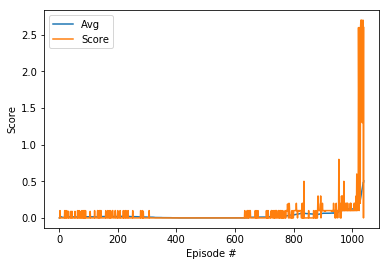

In [20]:
plt.plot(np.arange(1, len(averages)+1), averages)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['Avg', 'Score'], loc='upper left')
plt.show()

In [21]:
memory, cache = buffers
memory.save('experiences96_96.pkl')

### 5. See the pre-trained agent in action

In [22]:
def play(agent, episodes=3):
    for i_episode in range(episodes):
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = agent.act(states, add_noise=False)       # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
            time.sleep(.050)
        print('Ep No: {} Total score (averaged over agents): {}'.format(i_episode, np.max(scores)))

In [23]:
agent = DDPG(state_size=state_size, action_size=action_size, random_seed=23, 
             fc1_units=96, fc2_units=96)
agent.load('./saves/1039_96_96_actor.pth', './saves/1039_96_96_critic.pth')

In [24]:
play(agent, episodes=10)

Ep No: 0 Total score (averaged over agents): 2.7000000402331352
Ep No: 1 Total score (averaged over agents): 2.7000000402331352
Ep No: 2 Total score (averaged over agents): 2.600000038743019
Ep No: 3 Total score (averaged over agents): 2.7000000402331352
Ep No: 4 Total score (averaged over agents): 2.600000038743019
Ep No: 5 Total score (averaged over agents): 2.7000000402331352
Ep No: 6 Total score (averaged over agents): 2.7000000402331352
Ep No: 7 Total score (averaged over agents): 2.7000000402331352
Ep No: 8 Total score (averaged over agents): 2.600000038743019
Ep No: 9 Total score (averaged over agents): 2.7000000402331352
